# Домашка 
---------------------------------------

tldr:
    
* Выбрать архитектуру из рассказанных NST, pix2pix, CycleGAN$^1$
* Подберите к ней задачу, чтобы она вам нравилась
* Подберите еще одну задачу, которая уже решена (если не NST)
* Повторите решение, которое уже есть$^2$ (если не NST)
* Решите свою задачу

---------------------------------------
1. Расположены в порядке возрастания сложности и крутизны
2. Поверьте если вы сделаете этот пункт следующий будет в *разы* легче

## Если вы выбрали Neural Style Transfer
---------------------------------------
Тут все довольно просто на первый и на второй взгляд. Поэтому недосотаточно просто написать свою функцию потерь и сдать ноутбук. Если вы хотите приличных баллов, то у вас есть две опции:


1. Вы разделяете картинку на две части и переносите на них разные стили. <p><span style="color:red">Нельзя просто взять и два раза применить обычную архитектуру сначала к одной чати картинки, а потом к другой.</span></p> От вас ожидается, что вы отдадите нейросети два картинки стиля и она внутри себя(скорее внутри лосс функции) разделит выходную картинку на две части и к одной части применит один стиль, а к другой - второй. 

2. Вы переносите *одновременно* два стиля на одну картинку контента.
<p><span style="color:red">Нельзя просто взять и два раза применить обычную архитектуру сначала с одним стилем, а потом с другим.</span></p>
От вас ожидается, что вы модифицируете модель(скорее лосс модели) для того, чтобы два стиля учитывались с разными весами. 

## Если вы выбрали pix2pix
---------------------------------------------
Здесь от вас ожидается, что вы реализуете свою архитектуру для pix2pix модели. Пожалуйста не копируйте код из открытых репозиториев. Этот факт очень легко обнаружить. Перед тем, как приступить проверьте, что обе задачи, которые вы выбрали влезают на вашу видеокарту или на карту Google Colab. Если они не влезают, но вам все равно очень хочется, то вы можете израсходовать все безплатные триалы облаков(Google, Amazon, .. etc) во вселенной. 

## Если вы выбрали CycleGAN
--------------------------------------------
Здесь от вас ожидается, что вы реализуете свою архитектуру для CycleGAN модели. Пожалуйста не копируйте код из открытых репозиториев. Этот факт очень легко обнаружить. Перед тем, как приступить проверьте, что обе задачи, которые вы выбрали влезают на вашу видеокарту или на карту Google Colab. CycleGAN в этом смысле хуже, чем pix2pix, он ест больше памяти. Если они не влезают, но вам все равно очень хочется, то вы можете израсходовать все беcплатные триалы облаков(Google, Amazon, .. etc) во вселенной. 

## Remarks:
-----------------------------------------

* Это задание нужно для того, чтобы вы наступили на все грабли, что есть. Узнали об их существовании и научились обходить. Посмотрели на неработающие модели и поняли, что все тлен. Изгуглили весь интернет и в конце заставили это все работать. Поверьте, оно того стиот. Не откладывайте это задание на ночь перед сдачей, так как весь смысл \*пуф\* улетучится.

* У вас два союзника в этой борьбе:
    1. Оригинальная статья, те психи, что ее писала как то заставили свою модель работать. Их мысли, которыми они спроводили свое детище, позволят вам написать свой вариант алгоритма. 
    2. Гугл, он знает ответы на почти все ваши вопросы, но у него есть две ипостаси одна простая в обещении и вы все ее занаете(русскоязычная), а есть еще одна, которая кусается, но знает больше(англоязычная). Если не знаете языва - учите на ходу :)
    
* На самом деле у вас есть еще один союзник, это ментор проекта(или лектор или семинарист). Его ресурсом нужно пользоваться в ситуации, в которой вы не можете(занчит попытались и не вышло) найти ответов, используя Гугл и статью.

* Сдавать это все нужно следующим образом. Код вы кидаете на github и отправляете ссылку туда, куда вам сказали(в телеграм, степик или еще куда-то)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time
from pathlib import Path
from torchvision import transforms
from PIL import Image

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
import torch
torch.cuda.is_available()

True

In [4]:
TRAIN_DIR_B = Path('/home/muaddib/Documents/DL/HW19/facades/trainA')
TEST_DIR_B = Path('/home/muaddib/Documents/DL/HW19/facades/testA')
TRAIN_DIR_A = Path('/home/muaddib/Documents/DL/HW19/facades/trainB')
TEST_DIR_A = Path('/home/muaddib/Documents/DL/HW19/facades/testB')

In [5]:
from sklearn.model_selection import train_test_split
from utils import PicDataset

trainA = sorted(list(TRAIN_DIR_A.rglob('*.jpg')))
trainB = sorted(list(TRAIN_DIR_B.rglob('*.jpg')))

testA = sorted(list(TEST_DIR_A.rglob('*.jpg')))
testB = sorted(list(TEST_DIR_B.rglob('*.jpg')))


data = list(zip(trainA ,trainB ))

test_files = [list(l) for l in list(zip(testA ,testB ))]

train_files, val_files = train_test_split(data , test_size=0.25)

print(len(train_files), len(val_files), len(test_files) )

batch_size = 6

train_dataset = PicDataset(train_files)
val_dataset = PicDataset(val_files)
test_dataset = PicDataset(test_files)

#data_tr = DataLoader(train_dataset ,batch_size=batch_size, shuffle=True)
#data_val = DataLoader(val_dataset ,batch_size=batch_size, shuffle=True)
#data_ts = DataLoader(test_dataset ,batch_size=batch_size, shuffle=True)

#print(len(data_tr), len(data_val), len(data_ts) )

300 100 106


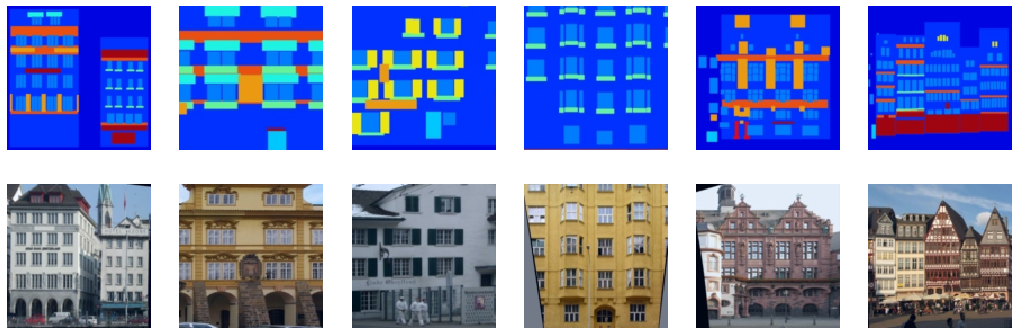

In [6]:
plt.figure(figsize=(18, 6))
for i in range(6):
    X, Y = val_dataset[i] 
    plt.subplot(2, 6, i+1)
    plt.axis("off")    
    X = X.numpy().transpose((1, 2, 0))
    X = (X-X.min())/(X.max()-X.min()) 
    plt.imshow(X)

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    Y = Y.numpy().transpose((1, 2, 0))
    Y = (Y-Y.min())/(Y.max()-Y.min()) 
    plt.imshow(Y/(Y.max() - Y.min()) - Y.min())
plt.show();

In [7]:
def lossGan(yPred, yReal, eps = 1e-7):
    #yReal = (yReal - yReal.min())/(yReal.max() - yReal.min())
    #yPred = (yPred - yPred.min())/(yPred.max() - yPred.min())
    #return  torch.mean(torch.log(eps+yReal)) + torch.mean(torch.log(eps + 1.0 - yPred))
    return torch.mean(torch.log(eps+torch.sigmoid(yReal))) + torch.mean(torch.log(eps + 1.0 - torch.sigmoid(yPred)))

In [8]:
from models import generatorNet
from models import discriminatorNet

gen = generatorNet().to(device)
dsc = discriminatorNet().to(device)

optimG = torch.optim.Adam(filter(lambda p: p.requires_grad, gen.parameters()),lr=0.0003)
optimD = torch.optim.Adam(filter(lambda p: p.requires_grad, dsc.parameters()),lr=0.0003)

#criterionGAN = nn.BCEWithLogitsLoss()
criterionGAN=lossGan
criterionL1 = torch.nn.L1Loss()

In [9]:
def train(epochs, data_tr, data_val, lambdaL1):
    train_loader = DataLoader(data_tr ,batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(data_val ,batch_size=batch_size, shuffle=True)
    historyLossD = []
    historyLossG = []
    
    A_val, B_val = next(iter(val_loader))
    
    for epoch in range(epochs):  
        avg_lossD = 0
        avg_lossG = 0
        gen.train()
        for A, B in train_loader:
            
            A = A.to(device)
            B = B.to(device)            
            
            optimD.zero_grad()
            
            generatedB = gen(A)            
           
            for param in dsc.parameters():
                param.requires_grad = True
            
            generatedAB = torch.cat((A, generatedB), 1)
            predGenerated = dsc(generatedAB.detach())
            
            lossDGenerated = criterionL1(predGenerated, torch.ones_like(predGenerated))
            
            realAB = torch.cat((A, B), 1)
            predReal = dsc(realAB.detach())
            
            lossDReal = criterionL1(predReal, torch.zeros_like(predReal))
            
            lossD = (lossDGenerated + lossDReal) / 2
            
            lossD.backward(retain_graph=True)
            
            optimD.step()
           
            
            optimG.zero_grad()
            
            for param in dsc.parameters():
                param.requires_grad = False
            
            predGenerated = dsc(generatedAB.detach())
            
            realAB = torch.cat((A, B), 1)
            
            predReal = dsc(realAB.detach())
            
            lossG_GAN = criterionGAN(predGenerated, predReal)
            
            lossG_L1 = criterionL1(generatedB, B) * lambdaL1
            
            lossG = lossG_GAN + lossG_L1
            
            lossG.backward()
            
            optimG.step()

            avg_lossD += float(lossD) / len(train_loader)
            avg_lossG += float(lossG) / len(train_loader)
            
        print('lossD: %f' % avg_lossD,";  ", 'lossG: %f' % avg_lossG )
        historyLossD.append(avg_lossD)
        historyLossG.append(avg_lossG)
        gen.eval() 
        B_hat = gen(A_val.to(device)).detach().cpu()
        B_val = (B_val-B_val.min())/(B_val.max()-B_val.min()) 
        B_hat = (B_hat-B_hat.min())/(B_hat.max()-B_hat.min())         
        if epoch % 10 == 0:
            plt.figure(figsize=(18, 6))
            for k in range(6):
                plt.subplot(2, 6, k+1)
                plt.imshow(np.rollaxis(B_val[k].numpy(), 0, 3), cmap='gray')
                plt.title('Real')
                plt.axis('off')            
                plt.subplot(2, 6, k+7)            
                plt.imshow(np.rollaxis(B_hat[k].numpy(), 0, 3), cmap='gray')
                plt.title('Output')
                plt.axis('off')        
            plt.show()    
    return historyLossD, historyLossG

In [10]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

lossD: 0.432967 ;   lossG: -1.462382


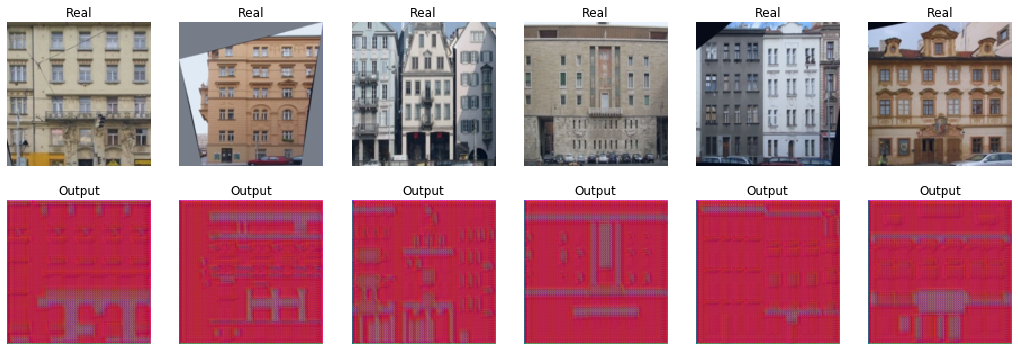

lossD: 0.339305 ;   lossG: -1.586792
lossD: 0.318754 ;   lossG: -1.614829
lossD: 0.304010 ;   lossG: -1.629409
lossD: 0.290193 ;   lossG: -1.645604
lossD: 0.285329 ;   lossG: -1.647025
lossD: 0.278472 ;   lossG: -1.656207
lossD: 0.273269 ;   lossG: -1.664328
lossD: 0.268535 ;   lossG: -1.666520
lossD: 0.262673 ;   lossG: -1.674564
lossD: 0.258423 ;   lossG: -1.680753


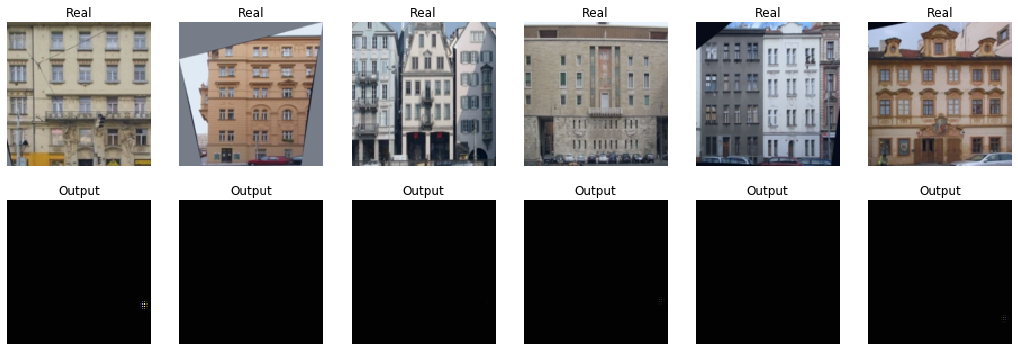

lossD: 0.253112 ;   lossG: -1.688289
lossD: 0.251671 ;   lossG: -1.692626
lossD: 0.247169 ;   lossG: -1.696179
lossD: 0.247460 ;   lossG: -1.697729
lossD: 0.240637 ;   lossG: -1.704304
lossD: 0.235776 ;   lossG: -1.712176
lossD: 0.235425 ;   lossG: -1.710221
lossD: 0.233903 ;   lossG: -1.715291
lossD: 0.231902 ;   lossG: -1.719668
lossD: 0.228714 ;   lossG: -1.721712


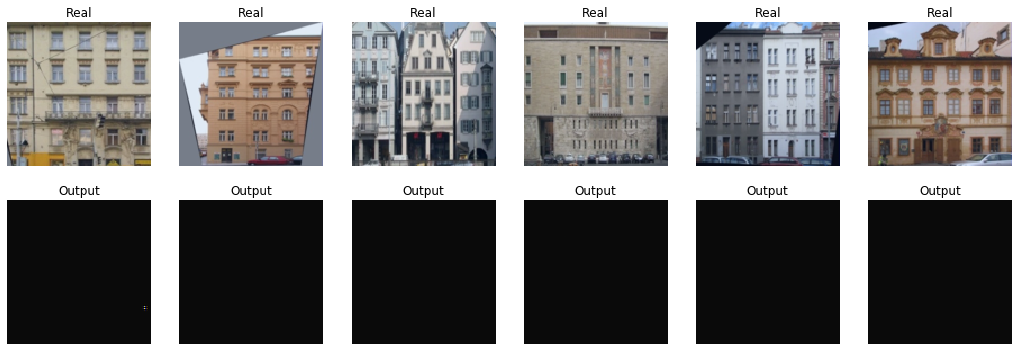

lossD: 0.224906 ;   lossG: -1.727004
lossD: 0.236710 ;   lossG: -1.707286
lossD: 0.223504 ;   lossG: -1.727309
lossD: 0.221496 ;   lossG: -1.731571
lossD: 0.218545 ;   lossG: -1.737423
lossD: 0.216726 ;   lossG: -1.735846
lossD: 0.211829 ;   lossG: -1.743102
lossD: 0.210088 ;   lossG: -1.744995
lossD: 0.209972 ;   lossG: -1.747977
lossD: 0.209223 ;   lossG: -1.748870


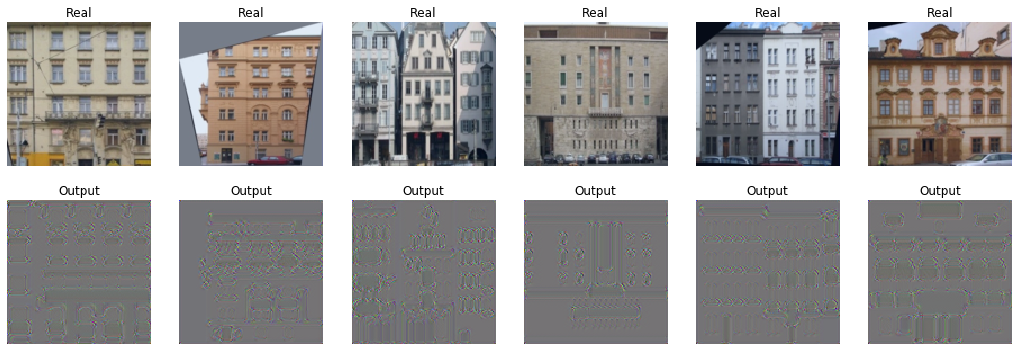

lossD: 0.206597 ;   lossG: -1.749673
lossD: 0.202009 ;   lossG: -1.755098
lossD: 0.199337 ;   lossG: -1.757029
lossD: 0.204281 ;   lossG: -1.755712
lossD: 0.200067 ;   lossG: -1.759230
lossD: 0.193740 ;   lossG: -1.763862
lossD: 0.195832 ;   lossG: -1.763645
lossD: 0.194688 ;   lossG: -1.768966
lossD: 0.195053 ;   lossG: -1.767718
lossD: 0.189000 ;   lossG: -1.770016


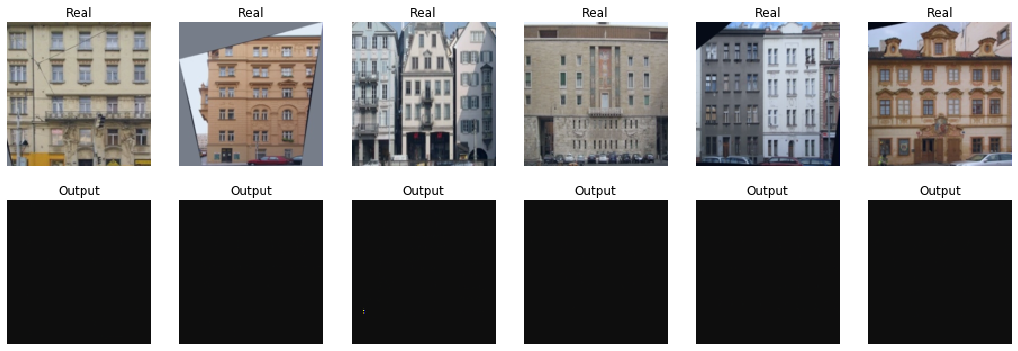

lossD: 0.185357 ;   lossG: -1.777831
lossD: 0.186461 ;   lossG: -1.775615
lossD: 0.188063 ;   lossG: -1.776646
lossD: 0.180356 ;   lossG: -1.782514
lossD: 0.182342 ;   lossG: -1.781824
lossD: 0.184574 ;   lossG: -1.780209
lossD: 0.185865 ;   lossG: -1.778270
lossD: 0.180196 ;   lossG: -1.785224


KeyboardInterrupt: 

In [11]:
train(50, train_dataset, val_dataset, 0.2)